In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import arviz as az
from edge_photometry import edge_model, jax_prng_key
import numpyro
import numpy as np
from numpyro.infer import NUTS, MCMC
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns

numpyro.enable_x64()
numpyro.set_host_device_count(4)

sns.set_context('notebook')

Here is the CMD for the points we are fitting, along with the TRGB inferred from [McQuinn, et al. (2017)](https://doi.org/10.3847/1538-3881/aa7aad).

In [McQuinn, et al. (2017)](https://iopscience.iop.org/article/10.3847/1538-3881/aa7aad), the metallicity correction is 
$$
A_\mathrm{F814W} = -4.06 + 0.2 \left( A_\mathrm{F606W} - A_\mathrm{F814W} - 1.23 \right).
$$

Putting this into our language, we have 
$$
A_\mathrm{F814W} - 0.2 \left( A_\mathrm{F606W} - A_\mathrm{F814W} - 1.23 \right) = -4.06 + \mu
$$
where $\mu$ is the distance modulus.  Thus we see that $c = -0.2$, and the centering parameter for $C = 1.23$, and then $e_\mathrm{centered} = -4.06 + \mu$.

[Rizzi, et al. (2007)](https://iopscience.iop.org/article/10.1086/516566) provides the TRGB slope used in McQuinn, et al. (2017) and gives an uncertainty of $0.01$, so we impose this with a prior.

In [12]:
data = pd.read_table('data/M63/M63_FOV_VIerr.dat', names=['V', 'Verr', 'I', 'Ierr'], delimiter=' ')

print('len(data) = {:d}'.format(len(data)))

trgb_mcquinn = 25.68
c_mcquinn = -0.2
c_center = 1.23

A0_cut = 27.0 # See below

# BAD, BAD, BAD!
Vext = 0.043
Iext = 0.027
data['V'] = data['V'] - Vext
data['I'] = data['I'] - Iext

data['V-I'] = data['V'] - data['I']
data['IRectMcQ'] = data['I'] + c_mcquinn*(data['V-I'] - c_center)

data_rgb = data
# rgb_mask = (data['V-I'] > 0.6) & (data['V-I'] < 2.5)
# data_rgb = data.loc[rgb_mask]

data_cut = data.loc[data['I'] < A0_cut]

Nfit = 2048
inds = np.random.permutation(len(data_cut))
data_cut = data_cut.iloc[inds[:Nfit]]

len(data) = 38821


From the CMD, we can see that if we cut at $I > 27.0$ we will stay well away from the TRGB.

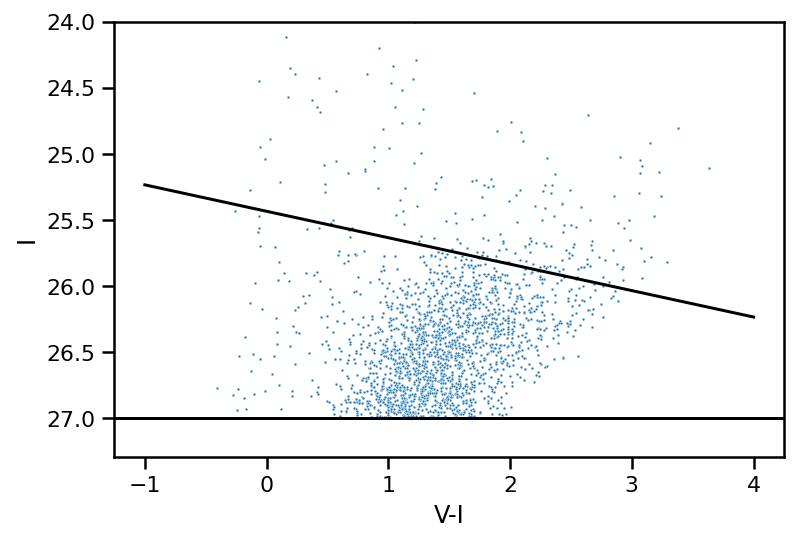

In [13]:
marker_s = 8

p = sns.scatterplot(data=data_cut, x='V-I', y='I', marker='.', s=marker_s)
yl, yh = p.axes.get_ylim()
yl = 24 # Force a good-looking plot
p.axes.set_ylim(yh, yl)

cs = np.linspace(-1, 4, 1024)
plt.plot(cs, trgb_mcquinn - c_mcquinn*(cs - c_center), 'k')

plt.axhline(A0_cut, color='k')

Or here is the result in "rectified" $I$ band.  The rectification seems to have made the "apparent" TRGB constant (i.e. flat in color), so that's good.

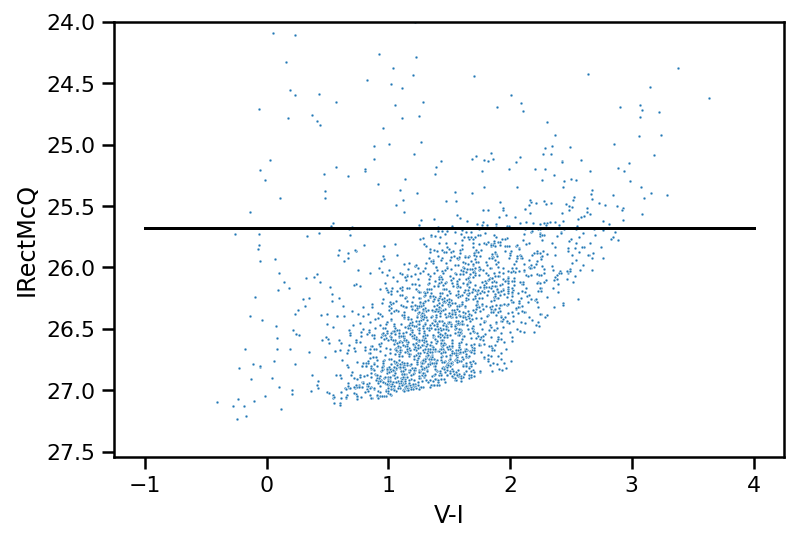

In [14]:
p = sns.scatterplot(data=data_cut, x='V-I', y='IRectMcQ', marker='.', s=marker_s)
yl, yh = p.axes.get_ylim()
yl = 24 # Force a good-looking plot
p.axes.set_ylim(yh, yl)

cs = np.linspace(-1, 4, 1024)
plt.plot(cs, trgb_mcquinn*np.ones_like(cs), 'k')

In [15]:
Aobs = np.column_stack((data_cut['I'], data_cut['V']))
sigma_obs = np.column_stack((data_cut['Ierr'], data_cut['Verr']))

c_mu = c_mcquinn
c_sigma = 0.01

e_center = 25.68
e_sigma = 0.1

In [16]:
num_chains=4
thinning=1
sampler = NUTS(edge_model, dense_mass=True)
mcmc = MCMC(sampler, num_chains=num_chains, num_warmup=1000*thinning, num_samples=1000*thinning, thinning=thinning)
mcmc.run(jax_prng_key(), Aobs, sigma_obs, A0_cut, e_center_mu=e_center, e_center_sigma=e_sigma, c_mu=c_mu, c_sigma=c_sigma, c_center=c_center)
trace = az.from_numpyro(mcmc)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

array([[<AxesSubplot:title={'center':'e_centered'}>,
        <AxesSubplot:title={'center':'e_centered'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>],
       [<AxesSubplot:title={'center':'mu_fg'}>,
        <AxesSubplot:title={'center':'mu_fg'}>],
       [<AxesSubplot:title={'center':'scale_fg'}>,
        <AxesSubplot:title={'center':'scale_fg'}>],
       [<AxesSubplot:title={'center':'f_bg'}>,
        <AxesSubplot:title={'center':'f_bg'}>]], dtype=object)

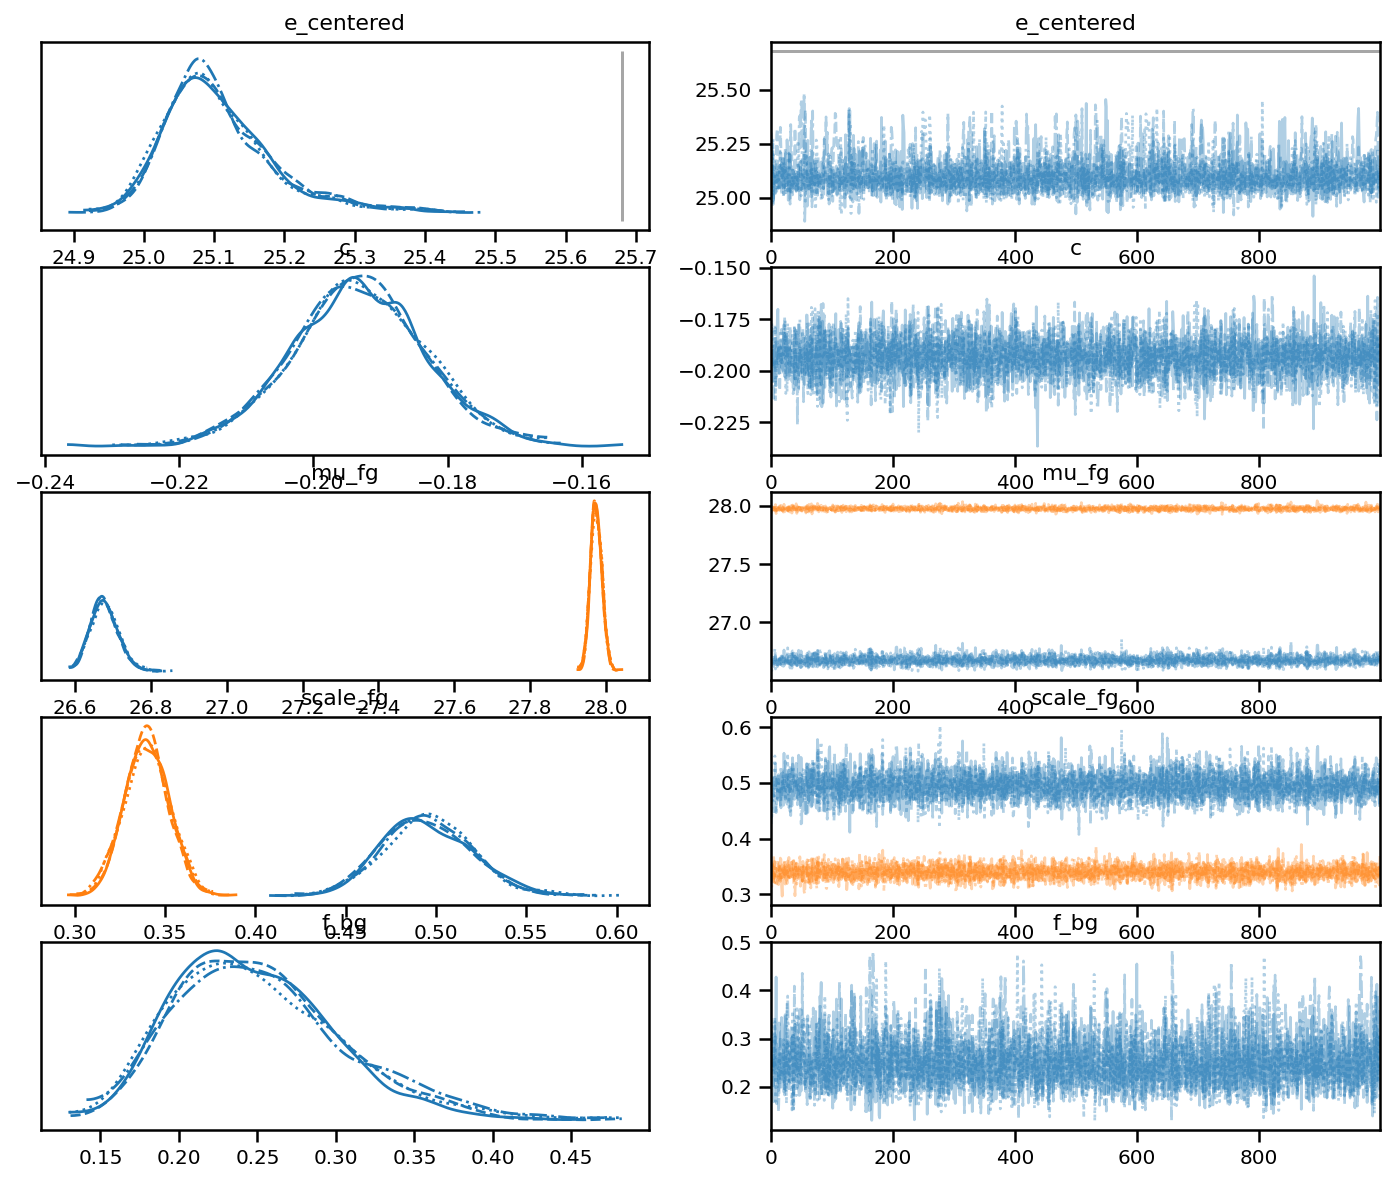

In [17]:
az.plot_trace(trace, var_names=['e_centered', 'c', 'mu_fg', 'scale_fg', 'f_bg'],
              lines=[('e_centered', {}, e_center)])

In [18]:
az.summary(trace, var_names=['e_centered', 'c', 'f_bg', 'mu_fg', 'cov_fg'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
e_centered,25.108,0.081,24.980,25.280,0.002,0.001,3624.0,1775.0,1.0
c[0],-0.193,0.010,-0.212,-0.174,0.000,0.000,5948.0,3048.0,1.0
f_bg,0.252,0.054,0.162,0.357,0.001,0.001,4594.0,2457.0,1.0
mu_fg[0],26.677,0.036,26.609,26.744,0.000,0.000,5529.0,2918.0,1.0
mu_fg[1],27.975,0.015,27.947,28.003,0.000,0.000,6961.0,3128.0,1.0
"cov_fg[0, 0]",0.246,0.025,0.200,0.290,0.000,0.000,4363.0,3343.0,1.0
"cov_fg[0, 1]",0.075,0.010,0.056,0.095,0.000,0.000,5532.0,3172.0,1.0
"cov_fg[1, 0]",0.075,0.010,0.056,0.095,0.000,0.000,5532.0,3172.0,1.0
"cov_fg[1, 1]",0.116,0.008,0.100,0.131,0.000,0.000,5953.0,3212.0,1.0


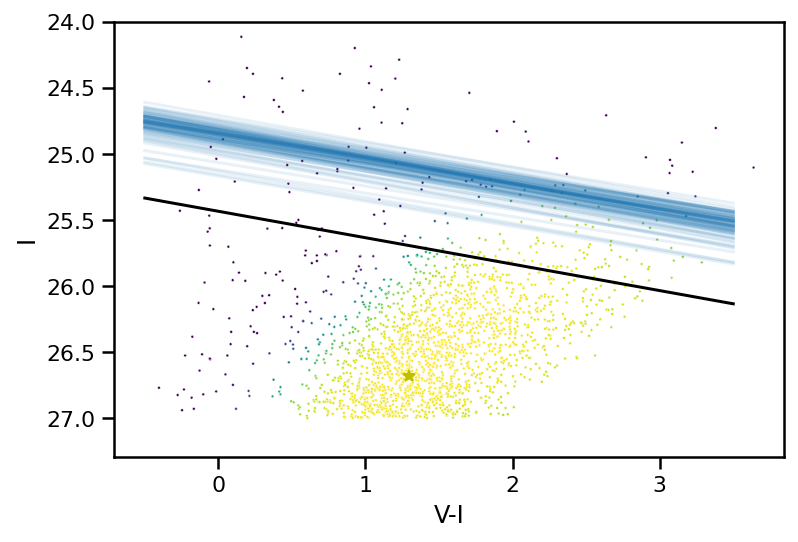

In [19]:
p = sns.scatterplot(data=data_cut, x='V-I', y='I', marker='.', c=np.exp(trace.posterior.log_fg_prob).mean(axis=(0,1)), s=marker_s)
yl, yh = p.axes.get_ylim()
yl = 24 # Force a good-looking plot
p.axes.set_ylim(yh, yl)

vis = np.linspace(-0.5, 3.5, 1024)
for _ in range(100):
    c = np.random.choice(trace.posterior.chain)
    d = np.random.choice(trace.posterior.draw)
    plt.plot(vis, trace.posterior.e_centered[c,d].values - trace.posterior.c[c,d,0].values*(vis - c_center), color=sns.color_palette()[0], alpha=0.1)
plt.plot(vis, trgb_mcquinn - c_mcquinn*(vis-c_center), color='k')

m = trace.posterior.mu_fg
plt.plot(m[:,:,1].mean()-m[:,:,0].mean(), m[:,:,0].mean(), '*y')
# mb = trace.posterior.mu_bg
# plt.plot(mb[:,:,1].mean()-m[:,:,0].mean(), m[:,:,0].mean(), '*b')

<AxesSubplot:title={'center':'e_centered'}>

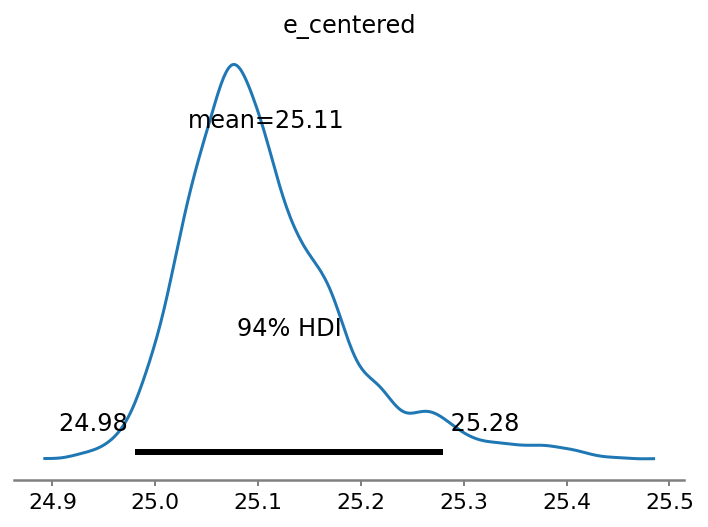

In [22]:
az.plot_posterior(trace, var_names='e_centered', round_to=4)

(27.5, 23.0)

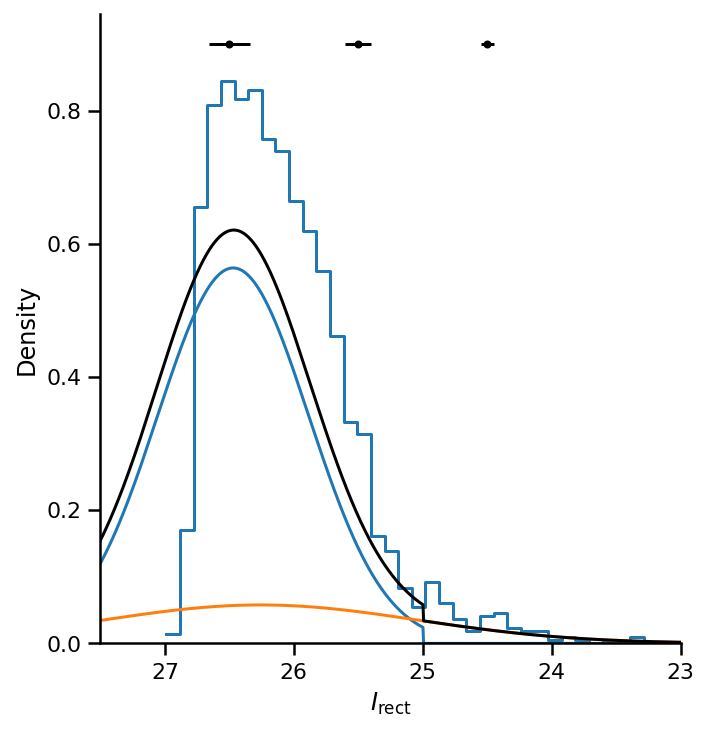

In [23]:
c = np.random.choice(trace.posterior.chain)
d = np.random.choice(trace.posterior.draw)

mu_f = trace.posterior.mu_fg[c,d,:].values
cov_f = trace.posterior.cov_fg[c,d,:,:].values
mu_bg = trace.posterior.mu_bg[c,d,:].values
cov_bg = trace.posterior.cov_bg[c,d,:,:].values
fb = trace.posterior.f_bg[c,d].values
w = trace.posterior.w[c,d,:].values
e = trace.posterior.e[c,d].values
cc = trace.posterior.c[c,d].values

mu_fe = np.dot(w, mu_f)
sigma_fe = np.sqrt(np.dot(w, np.dot(cov_f, w)))
mu_be = np.dot(w, mu_bg)
sigma_be = np.sqrt(np.dot(w, np.dot(cov_bg, w)))

Ae = np.dot(Aobs, w)

sns.displot(Ae, stat='density', element='step', fill=False)

Aes = np.linspace(23, 28, 1024)
p_bg = ss.norm(mu_be, sigma_be).pdf(Aes)
d_fg = ss.norm(mu_fe, sigma_fe)
p_fg = d_fg.pdf(Aes)*np.where(Aes > e, 1, 0)/(1-d_fg.cdf(e))
p = fb*p_bg + (1-fb)*p_fg
plt.plot(Aes, (1-fb)*p_fg)
plt.plot(Aes, fb*p_bg)
plt.plot(Aes, p, color='k')
#plt.axvline(e_center + c_center*cc, color='k')

errb = np.sqrt(np.dot(sigma_obs*sigma_obs, w*w))
for l in 27 - np.arange(3):
    mask = (Ae > l-1) & (Ae < l)
    plt.errorbar(l-0.5, 0.9, xerr=np.median(errb[mask]), fmt='.', color='k')
plt.xlabel(r'$I_\mathrm{rect}$')
plt.xlim(27.5, 23)